In [1]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import dougnet as dn
from dougnet.training import DataLoader, ProgressHelper
from dougnet.data import LoadCIFAR10
from dougnet.metrics import accuracy
import dougnet.functions as dnF

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import trange

In this notebook I explore the convolutional capabilities of dougnet by training several convolutional neural networks with the CIFAR-10 dataset with both DougNet and Pytorch (for comparison).  We will see a substantial increase in model accuracy compared to the multilayer perceptrons implemented in the previous notebook.  The models I consider are:
- LeNet
- AlexNet
- ResNet9

Additionally, in this notebook, I compare the performance in computation time between the naive, loop-based convolution algorithm and the efficient, GEMM based convolution algorithm.

# Load/Prep CIFAR-10 data

In [2]:
# DEFINE HELPER FUNC FOR LOADING CIFAR10 DATA
def PrepareData(X, y, n_classes, dtype=np.float32, seed=42):
    # one hot encode Ys
    Y_ohe = np.zeros((y.size, n_classes))
    Y_ohe[np.arange(y.size), y] = 1
    Y_ohe = Y_ohe.T
    
    # standardize
    X = ((X / 255.) - .5) * 2
    
    # get in N x C x H x W form
    X = X.transpose(0, 3, 1, 2)

    ## randomly shuffle images
    random_perm = np.random.RandomState(seed=seed).permutation(X.shape[0])
    X = X[random_perm, :, :, :]
    Y_ohe = Y_ohe[:, random_perm]
    
    return np.ascontiguousarray(X.astype(dtype)), np.ascontiguousarray(Y_ohe.astype(dtype))

# LOAD CIFAR10 DATA FOR TESTING AND DO BASIC DATA PREP
X_train, Y_train, X_val, Y_val = LoadCIFAR10()
X_train, Y_train = PrepareData(X_train, Y_train, 10)
X_val, Y_val = PrepareData(X_val, Y_val, 10)

# de-OHE ys
Y_train_deohe = np.argmax(Y_train, axis=0).astype(np.int64)
Y_val_deohe = np.argmax(Y_val, axis=0).astype(np.int64)

# turn data into tensors
X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train_deohe.reshape(-1), dtype=torch.long)
X_val_tensor = torch.tensor(X_val)
Y_val_tensor = torch.tensor(Y_val_deohe.reshape(-1), dtype=torch.long)

# Multi-Channel Convolution: Naive vs. GEMM implementations

In this section I compare the performance of the naive based convolution method and the gemm based convolution method.

In [3]:
# do some initial prep-work before timing functions

OUTPUT_CHANNELS = 64
H_K = 3

# instantiate pytorch's Conv2d and copy K, b for use with dougnet
conv2d_torch = nn.Conv2d(3, OUTPUT_CHANNELS, H_K)
K = conv2d_torch.weight.data.numpy().copy()
b = conv2d_torch.bias.data.numpy().copy()

# subset data for quicker testing
X_train_subset = X_train[:100, :, :, :]
X_train_tensor_subset = X_train_tensor[:100, :, :, :]

# do an initial run of dnF.conv2d() since a numba jitted initial run has significant overhead
# and will take longer than all subsequent runs (so that I don't include this initial long run
# in my timing)
_ = dnF.conv2d(X_train_subset, K, b, method="naive")
_ = dnF.conv2d(X_train_subset, K, b, method="gemm")

Time dougnet's naive and gemm based convolutions as well as pytorch's convolution for comparison.

In [4]:
%%timeit

_ = dnF.conv2d(X_train_subset, K, b, method="naive")

54.5 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%timeit

_ = dnF.conv2d(X_train_subset, K, b, method="gemm")

12.1 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit

_ = conv2d_torch(X_train_tensor_subset)

10.2 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# sanity check for correctness

Z_dn_naive = dnF.conv2d(X_train_subset, K, b, method="naive")
Z_dn_gemm = dnF.conv2d(X_train_subset, K, b, method="gemm")
Z_torch = conv2d_torch(X_train_tensor_subset)

assert np.allclose(Z_dn_naive, Z_torch.detach().numpy(), rtol=1e-6, atol=1e-6)
assert np.allclose(Z_dn_gemm, Z_torch.detach().numpy(), rtol=1e-6, atol=1e-6)

On my machine, I see an almost 5 fold decrease in computation time between the naive based convolution method and the gemm based convolution method.

# ConvNet Examples

In [8]:
SEED_DATALOADER = 1
SEED_WEIGHTS = 4
SEED_DROPOUT = 9
BATCH_SIZE = 100

### Define some training/plotting utility functions

In [9]:
# define helper function for training dougnet
def train_dougnet(graph, model, eta, epochs):
    
    # create loss node
    L = dn.SoftmaxCrossEntropyLoss(model_dn.module_output, model_dn.Y)
    
    # initialize weights
    graph.initialize_params(SEED_WEIGHTS)
    print(f"number of model parameters: {len(graph)}")
    initial_weights = []
    for node in model_dn.weighted_layers:
        if hasattr(node, "K"):
            initial_weights.append(node.K.output.copy())
        else:
            initial_weights.append(node.weight.output.copy())
    
    # train
    progress = ProgressHelper(epochs, model_dn.X, model_dn.Y, model_dn.module_output, 
                              L, progress_metric=accuracy)
    dataloader = DataLoader(X_train, Y_train, BATCH_SIZE, random_state=SEED_DATALOADER)
    optim = dn.optim.Adam(graph, eta=eta)
    for epoch in range(epochs):
        for X_B, Y_B in dataloader.load():
            model_dn.X.output, model_dn.Y.output = X_B, Y_B
            _ = L.forward()
            L.backward()
            optim.step()
        progress.update(X_train, Y_train, X_val, Y_val)
        
    return progress, initial_weights

In [10]:
# define helper function for training pytorch
def train_torch(model_pytorch, initial_weights, eta, epochs):

    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    def record_progress():
        """func to record training progress"""
        model_pytorch.eval()
        with torch.no_grad():
            # record train loss
            yhat_train = model_pytorch(X_train_tensor)
            loss_train.append(loss_fn(yhat_train, Y_train_tensor).item())    

            # record train accuracy
            is_correct = (torch.argmax(yhat_train, dim=1) == Y_train_tensor).float()
            accuracy_train.append((is_correct.sum() / yhat_train.shape[0]).item())

            # record val loss
            yhat_val = model_pytorch(X_val_tensor)
            loss_val.append(loss_fn(yhat_val, Y_val_tensor).item())    

            # record train accuracy
            is_correct = (torch.argmax(yhat_val, dim=1) == Y_val_tensor).float()
            accuracy_val.append((is_correct.sum() / yhat_val.shape[0]).item())
        model_pytorch.train()
        
        
    # initialize weights
    with torch.no_grad():
        for i in range(len(initial_weights)):
            model_pytorch.weighted_layers[i].weight = nn.Parameter(torch.tensor(initial_weights[i]))
            model_pytorch.weighted_layers[i].bias = nn.Parameter(torch.zeros(initial_weights[i].shape[0])) 
          
    # train
    loss_fn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model_pytorch.parameters(), lr=eta)
    dataloader = DataLoader(X_train, Y_train_deohe, BATCH_SIZE, random_state=SEED_DATALOADER) 
    for epoch in trange(epochs, desc="epoch", unit="epoch", bar_format='{l_bar}{bar:15}{r_bar}{bar:-10b}'):
        for X_B, Y_B in dataloader.load():
            X_B_tensor = torch.tensor(X_B)
            Y_B_tensor = torch.tensor(Y_B.reshape(-1), dtype=torch.long)

            yhat = model_pytorch(X_B_tensor)
            loss = loss_fn(yhat, Y_B_tensor)
            loss.backward()

            optim.step()
            optim.zero_grad()
        record_progress()
        
    return {"loss_train": loss_train, "acc_train": accuracy_train, "loss_val": loss_val, "acc_val": accuracy_val}

In [11]:
# define helper function for plotting learning curves
def plot_results(progress_dn, progress_torch, title):

    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    axs[0][0].plot(range(1, len(progress_dn.loss_train_) + 1), progress_dn.loss_train_)
    axs[0][0].plot(range(1, len(progress_dn.loss_val_) + 1), progress_dn.loss_val_)
    axs[0][0].set_ylabel("loss")
    axs[0][0].set_title("dougnet")

    axs[0][1].plot(range(1, len(progress_torch['loss_train']) + 1), progress_torch['loss_train'])
    axs[0][1].plot(range(1, len(progress_torch['loss_val']) + 1), progress_torch['loss_val'])
    axs[0][1].set_title("pytorch")

    axs[1][0].plot(range(1, len(progress_dn.score_train_) + 1), progress_dn.score_train_)
    axs[1][0].plot(range(1, len(progress_dn.score_val_) + 1), progress_dn.score_val_)
    axs[1][0].set_xlabel("epoch")
    axs[1][0].set_ylabel("accuracy")

    axs[1][1].plot(range(1, len(progress_torch['acc_train']) + 1), progress_torch['acc_train'])
    axs[1][1].plot(range(1, len(progress_torch['acc_val']) + 1), progress_torch['acc_val'])
    axs[1][1].set_xlabel("epoch")

    print(f"best dougnet validation accuracy = {round(np.max(progress_dn.score_val_), 3)}")
    print(f"best pytorch validation accuracy = {round(np.max(progress_torch['acc_val']), 3)}")

### LeNet

The original architecture of LeNet is shown in the following table alongside the output shapes following each operation (first two columns).  For comparison, the architecture (and output shapes) of the LeNet inspired model that I fit in this notebook is shown in the last two columns.  There are some slight differences between the original LeNet model and the LeNet model implemented here in kernel size, padding, stride and number of output channels.  This due to the fact that the original model was fit to the MNIST dataset which has a slightly different shape than the CIFAR-10 dataset which I am using (1 x 28 x 28 vs. 3 x 32 x 32).  Additionally, the kernel size, padding and stride must be tweaked slightly, since, in DougNet, the output shape of a convolution and a max-pool ($(height + 2*pad - kernel\_size + 1) / stride$) must be integer-valued.

Finally, the original LeNet model used a sigmoid function for the non-linearity and an average-pool following each convolution.  I replace these operations with their more modern counterpats: relu and max-pool.

| operation (original LeNet) | output shape (original LeNet) | operation           | output shape             | 
|--------------------------- | ----------------------------- |-------------------- | ------------------------ |
| input                      | 1 x 28 x 28 (C x H x W)       | input               | 3 x 32 x 32 (C x H x W)  |
|                            |                               |                     |                          |
| conv(out=6, k=5, p=2)      | 6 x 28 x 28                   | conv(out=C*6, k=5)  | 18 x 28 x 28             |
| sigmoid()                  | 6 x 28 x 28                   | relu()              | 18 x 28 x 28             |
| avgpool(k=2, s=2)          | 6 x 14 x 14                   | maxpool(k=3, s=2)   | 18 x 13 x 13             |
|                            |                               |                     |                          |
| conv(out=16, k=5)          | 16 x 10 x 10                  | conv(out=C*16, k=4) | 48 x 10 x 10             |
| sigmoid()                  | 16 x 10 x 10                  | relu()              | 48 x 10 x 10             |
| avgpool(k=2, s=2)          | 16 x 5 x 5                    | maxpool(k=3, s=2)   | 48 x 4 x 4               |
|                            |                               |                     |                          |
| flatten()                  | 400                           | flatten()           | 768                      |
| Linear(out=120)            | 120                           | Linear(out=C*120)   | 360                      |
| sigmoid()                  | 120                           | relu()              | 360                      |
|                            |                               |                     |                          |
| Linear(out=84)             | 84                            | Linear(out=C*84)    | 252                      |
| sigmoid()                  | 84                            | relu()              | 252                      |
|                            |                               |                     |                          |
| Linear(out=10)             | 10                            | Linear(out=10)      | 10                       |

In [12]:
# define LeNet model in both DougNet and Pytorch

class LeNetDN(dn.Module):
    def __init__(self, in_channels=3, num_classes=10):
    
        # input
        self.X = dn.InputNode()
        self.Y = dn.InputNode()
        
        # convolution layers
        z1 = dn.Conv2d(self.X, in_channels, 6*in_channels, kernel_size=5)
        a1 = dn.MP2d(dn.Relu(z1), H_K=3, W_K=3, stride=2)
        
        z2 = dn.Conv2d(a1, 6*in_channels, 16*in_channels, kernel_size=4)
        a2 = dn.MP2d(dn.Relu(z2), H_K=3, W_K=3, stride=2)
        
        # classifier
        z3 = dn.Linear(dn.Flatten(dn.Transpose(a2, (1, 2, 3, 0)), 3), 
                       120*in_channels, 
                       4*4*16*in_channels, weight_init="xavier")
        a3 = dn.Relu(z3.module_output)

        z4 = dn.Linear(a3, 84*in_channels, 120*in_channels, weight_init="xavier")
        a4 = dn.Relu(z4.module_output)

        self.z5 = dn.Linear(a4, num_classes, 84*in_channels, weight_init="xavier")
        
        self.weighted_layers = [z1, z2, z3, z4, self.z5]
        super().__init__()
        
    def forward_(self):
        return self.z5.module_output
    
    
class LeNetTorch(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(4*4*16*in_channels, 120*in_channels),
            nn.ReLU(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.ReLU(),
            nn.Linear(84*in_channels, num_classes),
        )
        
        self.weighted_layers  = [self.features[0], 
                                 self.features[3], 
                                 self.classifier[0], 
                                 self.classifier[2], 
                                 self.classifier[4]
                                ]

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [13]:
# train
epochs = 10
eta = 0.001

graph = dn.ComputationGraph()
model_dn = LeNetDN()
model_pytorch = LeNetTorch()

progress_dn, initial_weights= train_dougnet(graph, model_dn, eta, epochs)
progress_torch = train_torch(model_pytorch, initial_weights, eta, epochs)

number of model parameters: 385582


epoch: 100%|███████████████| 10/10 [06:09<00:00, 36.92s/epoch]                                               


best dougnet validation accuracy = 0.711
best pytorch validation accuracy = 0.712


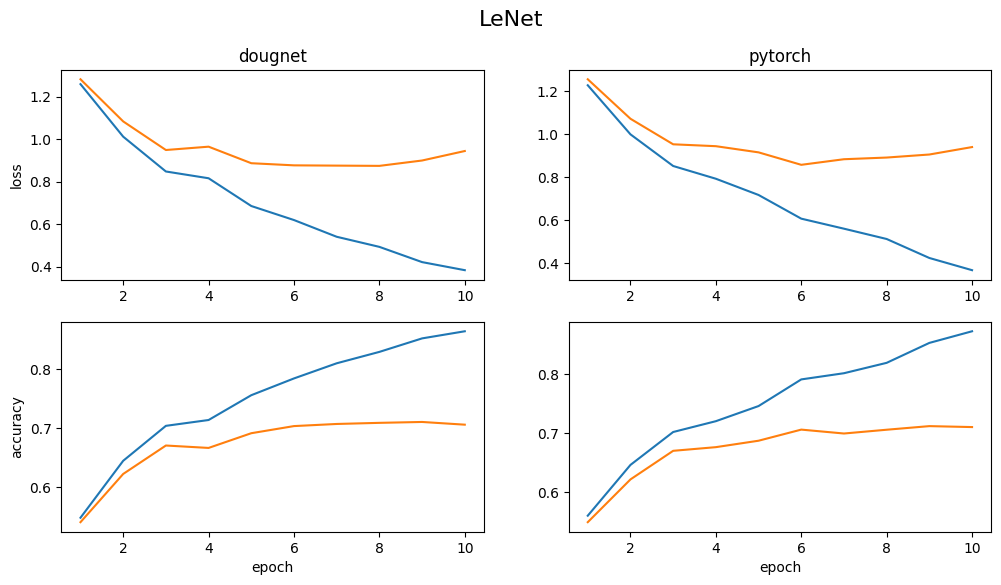

In [14]:
# plot results
plot_results(progress_dn, progress_torch, "LeNet")

LeNet was one of the earliest convolutional neural networks invented in the 90s.  Even with this rudimentary conv-net architecture, examining the test-set accuracy of LeNet ($\sim 71 \%$) compared to the test-set accuracies obtained with the MLPs ($\sim 55 \%$) from the initialization and optimization notebook, we see a dramatic improvement in performance.

### AlexNet

I now train the AlexNet architecture with both DougNet and Pytorch.  Note that since AlexNet was originally designed for input images of size $224 \times 224$ and since the CIFAR-10 images are $32 \times 32$, the first layer in my implementation has slightly different kernel sizes and strides.  Also note that, compared to LeNet, AlexNet is significantly more computationally expensive.  Since I am training these models on a CPU, I therefore scale down all channels/features by a factor of 8 in the network.  Training on a GPU would be significantly faster.

Finally, note that in my Pytorch implementation of AlexNet, I do not use pytorch's nn.Dropout(.) class and instead implement dropout with a custom dropout(.) function defined below.  I do this for fair comparison to my Dougnet model, since this allows me to use the same exact numpy rng to generate the same sequence of masks that the dougnet model uses during training.

Even when scaling down the channels/features, on my laptop, the total training time for the DougNet and Pytorch models is about $\sim 3$ hours, so when running the code below it is best to step away from this notebook for a bit.

In [15]:
# define AlexNet in both dougnet and pytorch

class AlexNetDN(dn.Module):
    def __init__(self, num_classes=10, scale_features=1, p=.5, dropout_seed=None):
        self.p = p
        self.random_state = np.random.RandomState(dropout_seed)
        
        # input
        self.X = dn.InputNode()
        self.Y = dn.InputNode()
        
        # convolution layers
        z1 = dn.Conv2d(self.X, 3, 96//scale_features, kernel_size=5) #(28 x 28)
        a1 = dn.MP2d(dn.Relu(z1), H_K=3, W_K=3, stride=1) #(26 x 26)
        
        z2 = dn.Conv2d(a1, 96//scale_features, 256//scale_features, kernel_size=5, pad=2) #(26 x 26)
        a2 = dn.MP2d(dn.Relu(z2), H_K=3, W_K=3, stride=2) #(12 x 12)
        
        z3 = dn.Conv2d(a2, 256//scale_features, 384//scale_features, kernel_size=3, pad=1) #(12 x 12)
        a3 = dn.Relu(z3)
        
        z4 = dn.Conv2d(a3, 384//scale_features, 384//scale_features, kernel_size=3, pad=1) #(12 x 12)
        a4 = dn.Relu(z4)
        
        z5 = dn.Conv2d(a4, 384//scale_features, 256//scale_features, kernel_size=3, pad=1) #(12 x 12)
        a5 = dn.MP2d(dn.Relu(z5), H_K=3, W_K=3, stride=2) #(5 x 5)
        
        # classifier layers
        z6 = dn.Linear(dn.Flatten(dn.Transpose(a5, (1, 2, 3, 0)), 3), 4096//scale_features, 
                       256//scale_features*5*5, weight_init="xavier")
        a6 = dn.Dropout(dn.Relu(z6.module_output), self.p, self.random_state)

        z7 = dn.Linear(a6, 4096//scale_features, 4096//scale_features, weight_init="xavier")
        a7 = dn.Dropout(dn.Relu(z7.module_output), self.p, self.random_state)

        self.z8 = dn.Linear(a7, num_classes, 4096//scale_features, weight_init="xavier")
        
        self.weighted_layers = [z1, z2, z3, z4, z5, z6, z7, self.z8]
        super().__init__()
        
    def forward_(self):
        return self.z8.module_output
    
    
def dropout(x, p, random_state, training):
    if training:
        mask = torch.tensor((random_state.binomial(1, 1-p, size=(x.shape[1], x.shape[0])) / (1 - p)
                            ).astype(np.float32))
        mask = mask.T
        return mask * x
    return x
    
    
class AlexNetTorch(nn.Module):
    def __init__(self, num_classes=10, scale_features=1, p=.5, dropout_seed=None):
        super().__init__()
        self.p = p
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 96//scale_features, kernel_size=5), #(28 x 28)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1), #(26 x 26)
            
            nn.Conv2d(96//scale_features, 256//scale_features, kernel_size=5, padding=2), #(26 x 26)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #(12 x 12)
            
            nn.Conv2d(256//scale_features, 384//scale_features, kernel_size=3, padding=1), #(12 x 12)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384//scale_features, 384//scale_features, kernel_size=3, padding=1), #(12 x 12)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384//scale_features, 256//scale_features, kernel_size=3, padding=1), #(12 x 12)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) #(5 x 5)
        )
        
        self.classifier1 = nn.Sequential(
            nn.Linear(256//scale_features*5*5, 4096//scale_features),
            nn.ReLU(inplace=True)
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(4096//scale_features, 4096//scale_features),
            nn.ReLU(inplace=True)
        )
        self.classifier3 = nn.Linear(4096//scale_features, num_classes) 
        
        self.weighted_layers  = [self.features[0], 
                                 self.features[3], 
                                 self.features[6], 
                                 self.features[8],
                                 self.features[10],
                                 self.classifier1[0], 
                                 self.classifier2[0], 
                                 self.classifier3
                                ]

        self.random_state = np.random.RandomState(dropout_seed)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        
        x = dropout(self.classifier1(x), self.p, self.random_state, self.training)
        x = dropout(self.classifier2(x), self.p, self.random_state, self.training)
        return self.classifier3(x)

In [16]:
# train alexnet
epochs = 20
eta = 0.001

graph = dn.ComputationGraph()
model_dn = AlexNetDN(num_classes=10, scale_features=8, dropout_seed=SEED_DROPOUT)
model_pytorch = AlexNetTorch(num_classes=10, scale_features=8, dropout_seed=SEED_DROPOUT)

progress_dn, initial_weights= train_dougnet(graph, model_dn, eta, epochs)
progress_torch = train_torch(model_pytorch, initial_weights, eta, epochs)

number of model parameters: 736954


epoch: 100%|███████████████| 20/20 [47:16<00:00, 141.82s/epoch]                                              


best dougnet validation accuracy = 0.734
best pytorch validation accuracy = 0.728


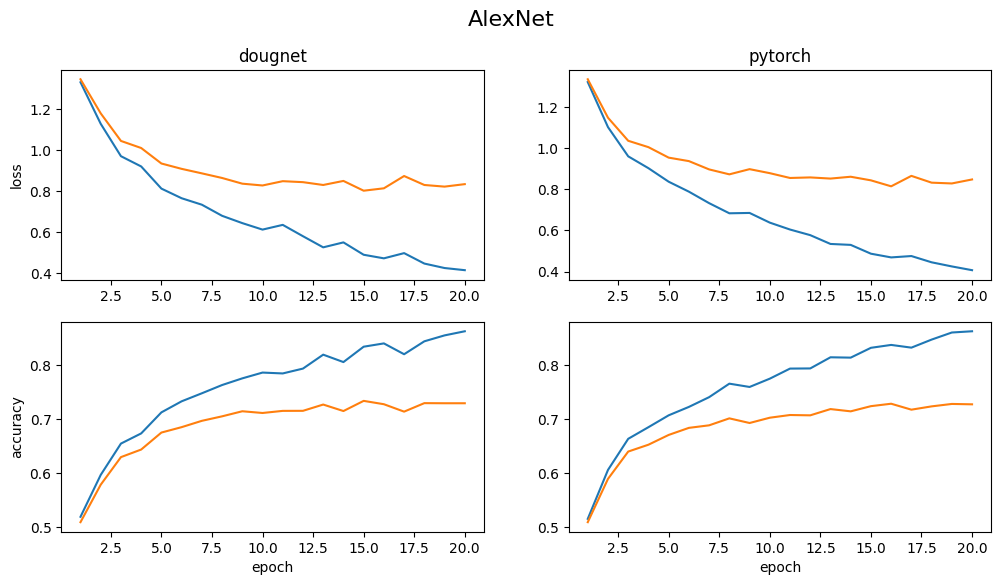

In [17]:
# plot results
plot_results(progress_dn, progress_torch, "AlexNet")

We see a moderate improvement in performance compared to LeNet.  For reference I have trained the full AlexNet architecture on a GPU (where the channels/features are not scaled down) and this results in similar validation accuracy.

### ResNet

The final (and most modern) conv-net architecture I train in this notebook is the ResNet architecture.  The ResNet architecture indcludes a so-called residual connection, which allows for very deep conv-nets to be trained.  Since I am training on a CPU, for the sake of time, I consider a relatively shallow architecture, ResNet9 which has 9 hidden layers and 1 output layer (the first 8 layers are convolution layers, and the last 2 layers are a fully connected MLP).  The ResNet architecture consists of a sequence of convolution blocks and residual blocks defined as:

$conv\_block(out, k, p, s) = conv(out, k, p, s) \rightarrow batchnorm() \rightarrow relu()$
$resid\_block(out, k, p, s) = conv(out, k, p, s) \rightarrow batchnorm() \rightarrow relu() \rightarrow conv(out, k, p, s) \rightarrow batchnorm() \rightarrow relu() + input$,

followed by a shallow MLP.  The ResNet9 architecture is shown in the table below (left hand column).  To save training time, I implement the architecture shown in the middle column which scales all output channels/features by a factor, $f$.  Further, to save training time, I dispense with the $maxpool(k=2, s=2)$ operation following each $conv\_block$ layer since the same reduction in the receptive field can equivalently be accomplished by setting $s=2$ in the $conv\_block$ layer.

Note that the total training for these models on my laptop took about an hour.

| operation (original ResNet9)        | operation                                | output shape              |
| ----------------------------------- | ---------------------------------------- | ------------------------- |
| input                               | input                                    | 3 x 32 x 32               |
|                                     |                                          |                           |
| conv_block(out=64, k=1, p=1, s=1)   | conv_block(out=64 // f, k=1, p=1, s=1)   | 64 // f x 32 x 32         |
|                                     |                                          |                           |
| conv_block(out=128, k=1, p=1, s=1)  | conv_block(out=128 // f, k=1, p=1, s=2)  |                           |
| maxpool(k=2, 2=2)                   |                                          | 128 // f x 16 x 16        |
|                                     |                                          |                           |
| resid_block(out=128, k=1, p=1, s=1) | resid_block(out=128 // f, k=1, p=1, s=1) | 128 // f x 16 x 16        |
|                                     |                                          |                           |
| conv_block(out=256, k=1, p=1, s=1)  | conv_block(out=256 // f, k=1, p=1, s=2)  |                           |
| maxpool(k=2, 2=2)                   |                                          | 256 // f x 8 x 8          |
|                                     |                                          |                           |
| conv_block(out=512, k=1, p=1, s=1)  | conv_block(out=512 // f, k=1, p=1, s=2)  |                           |   
| maxpool(k=2, 2=2)                   |                                          | 512 // f x 4 x 4          |
|                                     |                                          |                           | 
| resid_block(out=512, k=1, p=1, s=1) | resid_block(out=512 // f, k=1, p=1, s=1) | 512 // f x 4 x 4          |
| global_avg_pool()                   | global_avg_pool()                        | 512 // f                  |
|                                     |                                          |                           |
| Linear(out=512)                     | Linear(out=512 // f)                     | 512 // f                  |
| relu()                              | relu()                                   |                           |
|                                     |                                          |                           |
| Linear(out=10)                      | Linear(out=10)                           | 10                        |

In [18]:
# define ResNet9 in both dougnet and pytorch

class ResidualBlockDN(dn.Module):
    def __init__(self, v, in_channels, out_channels, kernel_size, padding):
        self.v = v
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        super().__init__()

    def forward_(self):
        residual = self.v
        conv1 = dn.Conv2d(self.v, 
                          self.in_channels,
                          self.out_channels, 
                          kernel_size=self.kernel_size,
                          pad=self.padding, 
                          bias=False)
        out = dn.Relu(dn.BN2d(conv1, self.out_channels))
        conv2 = dn.Conv2d(out,
                          self.out_channels, 
                          self.out_channels, 
                          kernel_size=self.kernel_size,
                          pad=self.padding, 
                          bias=False)
        out = dn.Relu(dn.BN2d(conv2, self.out_channels)) + residual
        self.weighted_layers = [conv1, conv2]
        return out


class ResNet9DN(dn.Module):
    def __init__(self, num_classes=10, scale_features=1):
        
        # input
        self.X = dn.InputNode()
        self.Y = dn.InputNode()
        
        # convolution layers
        z1 = dn.Conv2d(self.X, 3, 64//scale_features, kernel_size=3, stride=1, pad=1, bias=False) #(32 x 32)
        a1 = dn.Relu(dn.BN2d(z1, 64//scale_features))

        z2 = dn.Conv2d(a1, 64//scale_features, 128//scale_features, kernel_size=3, stride=2, pad=1, bias=False) #(16 x 16)
        a2 = dn.Relu(dn.BN2d(z2, 128//scale_features))

        a3 = ResidualBlockDN(a2, 128//scale_features, 128//scale_features, kernel_size=3, padding=1) #(16 x 16)

        z4 = dn.Conv2d(a3.module_output, 128//scale_features, 256//scale_features, kernel_size=3, stride=2, pad=1, bias=False) #(8 x 8)
        a4 = dn.Relu(dn.BN2d(z4, 256//scale_features))

        z5 = dn.Conv2d(a4, 256//scale_features, 512//scale_features, kernel_size=3, stride=2, pad=1, bias=False) #(4 x 4)
        a5 = dn.Relu(dn.BN2d(z5, 512//scale_features))

        a6 = ResidualBlockDN(a5, 512//scale_features, 512//scale_features, kernel_size=3, padding=1) #(4 x 4)
        
        # classifier layers
        z7 = dn.Linear(dn.GAP2d(a6.module_output), 512//scale_features, 512//scale_features, weight_init="xavier")
        a7 = dn.Relu(z7.module_output)

        self.z8 = dn.Linear(a7, num_classes, 512//scale_features, weight_init="xavier")        
        
        self.weighted_layers = [z1, z2] + a3.weighted_layers + [z4, z5] + a6.weighted_layers + [z7, self.z8]
        super().__init__()
        
    def forward_(self):
        return self.z8.module_output


class ResidualBlockTorch(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,
                               out_channels, 
                               kernel_size=kernel_size,
                               padding=padding, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, 
                               out_channels, 
                               kernel_size=kernel_size,
                               padding=padding, 
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.weighted_layers = [self.conv1, self.conv2]

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = out + residual
        return out
    
class ResNet9Torch(nn.Module):
    def __init__(self, num_classes=10, scale_features=1):
        super().__init__()
    
        self.features = nn.Sequential(
            nn.Conv2d(3, 64//scale_features, kernel_size=3, stride=1, padding=1, bias=False), #(32 x 32)
            nn.BatchNorm2d(64//scale_features),
            nn.ReLU(inplace=True),

            nn.Conv2d(64//scale_features, 128//scale_features, kernel_size=3, stride=2, padding=1, bias=False), #(16 x 16)
            nn.BatchNorm2d(128//scale_features),
            nn.ReLU(inplace=True),

            ResidualBlockTorch(128//scale_features, 128//scale_features, kernel_size=3, padding=1), #(16 x 16)

            nn.Conv2d(128//scale_features, 256//scale_features, kernel_size=3, stride=2, padding=1, bias=False), #(8 x 8)
            nn.BatchNorm2d(256//scale_features),
            nn.ReLU(inplace=True),

            nn.Conv2d(256//scale_features, 512//scale_features, kernel_size=3, stride=2, padding=1, bias=False), #(4 x 4)
            nn.BatchNorm2d(512//scale_features),
            nn.ReLU(inplace=True),

            ResidualBlockTorch(512//scale_features, 512//scale_features, kernel_size=3, padding=1), #(4 x 4)
        )
    
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512//scale_features, 512//scale_features),
            nn.ReLU(inplace=True),
            nn.Linear(512//scale_features, num_classes),
            )
        
        self.weighted_layers = [self.features[0], self.features[3]] + self.features[6].weighted_layers + \
                               [self.features[7], self.features[10]] + self.features[13].weighted_layers + \
                               [self.classifier[0], self.classifier[2]]
                                
    def forward(self, x):
        x = self.features(x) 
        x = torch.squeeze(self.global_avg_pool(x))
        return self.classifier(x)

In [19]:
# train resnet9
epochs = 20
eta = 0.001

graph = dn.ComputationGraph()
model_dn = ResNet9DN(num_classes=10, scale_features=8)
model_pytorch = ResNet9Torch(num_classes=10, scale_features=8)

progress_dn, initial_weights= train_dougnet(graph, model_dn, eta, epochs)
progress_torch = train_torch(model_pytorch, initial_weights, eta, epochs)

number of model parameters: 108114


epoch: 100%|███████████████| 20/20 [17:17<00:00, 51.86s/epoch]                                               


best dougnet validation accuracy = 0.72
best pytorch validation accuracy = 0.716


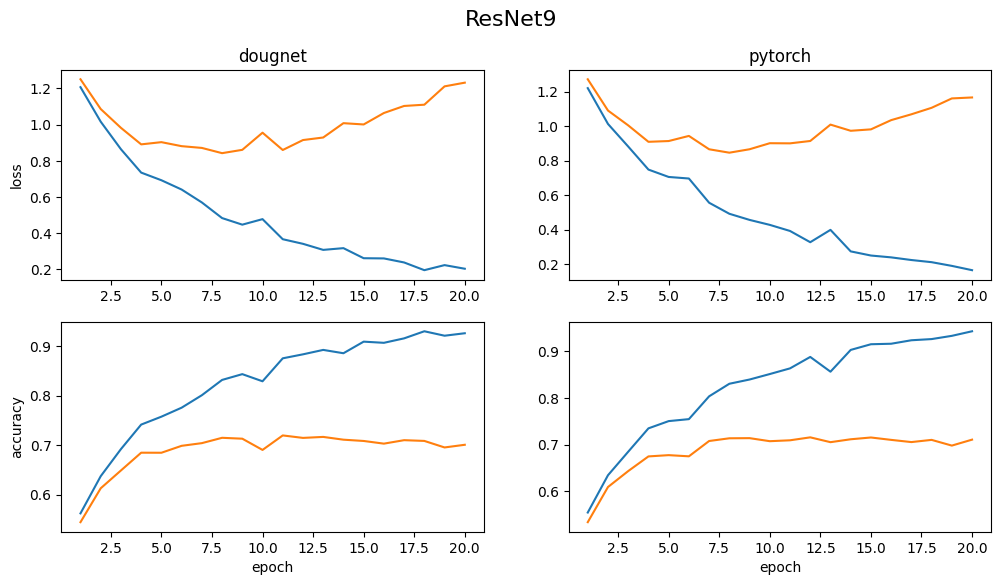

In [20]:
# plot results
plot_results(progress_dn, progress_torch, "ResNet9")

We see similar performance compared to AlexNet. However, training the full model where the output channels/features are not scaled down (scale_factor=1) on a GPU achieves a validation accuracy of ~83%, significantly better than AlexNet.